### Direct links to results
[Profile metrics](#profile)

[Count metrics](#count)

In [1]:
import h5py
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import vdom.helpers as vdomh
from IPython.display import display

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define constants and paths

In [3]:
# Define parameters/fetch arguments
metrics_dir = os.environ["TFM_METRICS_DIR"]
preds_path = os.environ["TFM_PRED_PATH"]
test_chroms = os.environ["TEST_CHROMS"] # Set to None or empty list for all chromosomes
   
print("Performance metrics directory: %s" % metrics_dir)
print("Predictions path: %s" % preds_path)

Performance metrics directory: /users/vir/temp/predictions/
Predictions path: /users/vir/temp/predictions/ENCSR000AHD_split000_predictions.h5


In [4]:
# Constants

metric_keys = [
    "mnll", "jsd", "cross_entropy", "pearson", "spearman", "mse",
    "counts_pearson", "counts_spearman"
]

metric_names = {
    "mnll": "normalized MNLL",
    "jsd": "normalized JSD",
    "cross_entropy": "normalized cross entropy",
    "pearson": "Pearson correlation",
    "spearman": "Spearman correlation",
    "mse": "MSE",
    "counts_pearson": "Pearson correlation",
    "counts_spearman": "Spearman correlation"
}

strands = ["minus", "plus"]

### Helper functions
For extracting metrics values, plotting, etc.

In [5]:
def extract_performance_metrics(metrics_dir):
    """
    Extracts the set of performance metrics from the directory of saved metrics.
    Strands are pooled
    Returns a dictionary of the following form:
        `mnll`: <MNLL vector over peaks/strands>
        `counts_pearson`: [
            <MSE scalar for negative strand>
            <MSE scalar for positive strand>
        ]
        ...
    """
    result = {}
    
    for key in metric_keys:
        vecs = []
        path = os.path.join(metrics_dir, key + ".npz")
        reader = np.load(path)
        vecs.append(reader[key])
            
        if key.startswith("counts_"):
            result[key] = np.array(vecs)
        else:
            result[key] = np.concatenate(vecs)
            
    return result

In [6]:
def import_true_pred_log_counts(preds_path, chrom_set=None):
    """
    Imports the true and predicted log counts as two N x 2 arrays.
    """
    with h5py.File(preds_path, "r") as f:
        chroms = f["coords"]["coords_chrom"][:].astype(str)
        if chrom_set:
            subset_inds = np.sort(np.where(np.isin(chroms, chrom_set))[0])
        else:
            subset_inds = np.arange(len(chroms))
                        
        true_log_counts = f["predictions"]["true_logcounts"][subset_inds]
        pred_log_counts = f["predictions"]["pred_logcounts"][subset_inds]
    return true_log_counts, pred_log_counts

In [7]:
def gradient_image(ax, extent, direction=0, cmap_range=(0, 1), **kwargs):
    """
    Adapted from
    https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/gradient_bar.html
    """
    phi = np.abs(direction) * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    if direction < 0:
        X = np.flip(X)
    im = ax.imshow(X, extent=extent, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im

### Import performance metrics/bounds

In [8]:
# Import metrics
metrics = extract_performance_metrics(metrics_dir)

In [9]:
# Import true/predicted log counts
true_log_counts, pred_log_counts = import_true_pred_log_counts(preds_path, chrom_set=test_chroms)

In [22]:
# Check that all the sizes are the same
for key in metric_keys:
    if key.startswith("counts_"):
        assert np.shape(metrics[key]) == true_log_counts[0:1,:].shape
    else:
        assert np.shape(metrics[key]) == true_log_counts.shape

<a id="profile"></a>
### Profile metrics
Shown as CDFs of min-max-normalized values. Strands are pooled. Note that a MNLL, cross entropy, JSD, and MSE are best when minimized. Pearson and Spearman correlation are best when maximized.

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


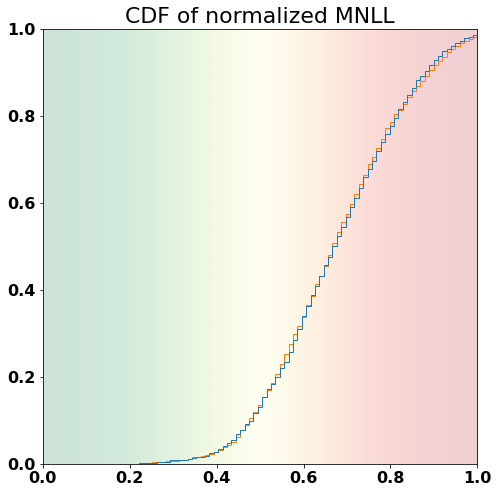

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


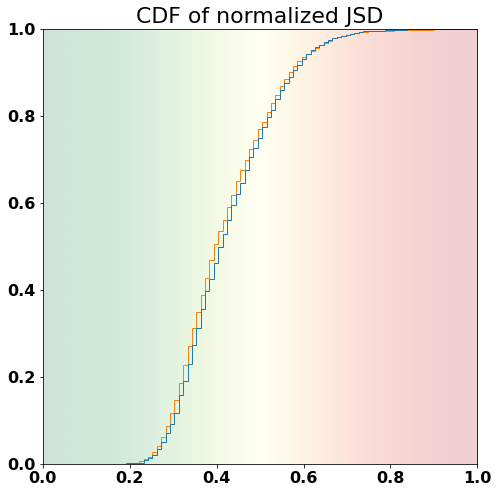

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


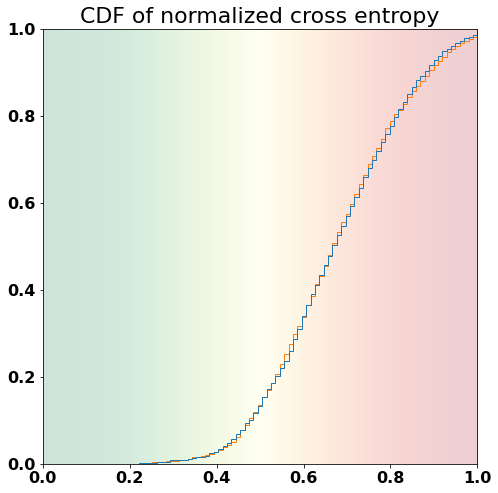

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


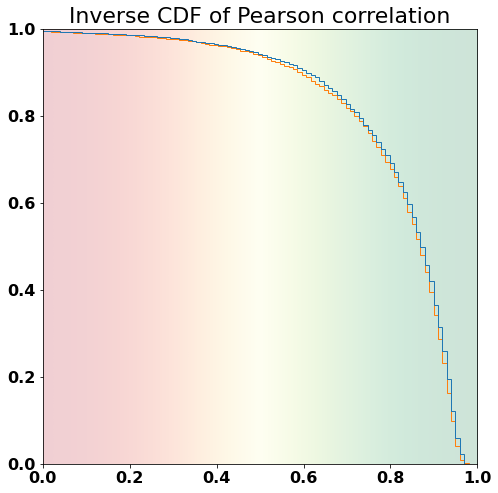

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


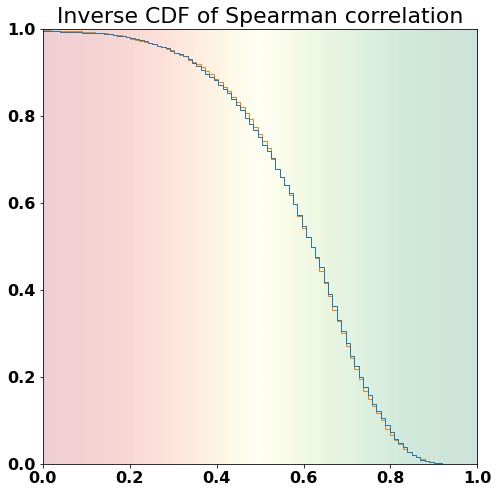

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


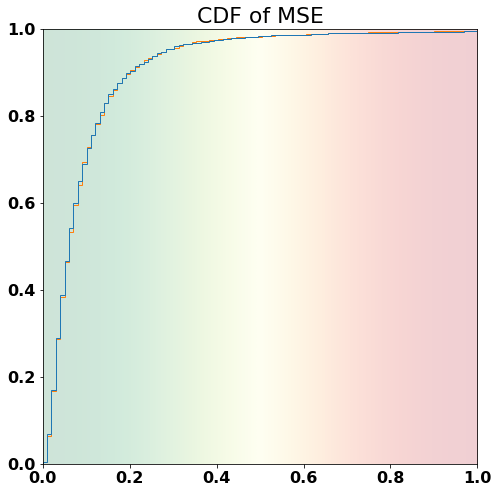

In [23]:
for key in metric_keys:
    if key.startswith("counts_"):
        continue
    
    fig, ax = plt.subplots(figsize=(8, 8))
    if key in ("pearson", "spearman"):
        gradient_image(
            ax, direction=1, extent=(0, 1, 0, 1), transform=ax.transAxes,
            cmap="RdYlGn", cmap_range=(0, 1), alpha=0.2
        )
        bins = np.concatenate([[-np.inf], np.linspace(0, 1, num=100)])
        ax.hist(metrics[key], bins=bins, density=True, histtype="step", cumulative=-1)
        ax.set_title("Inverse CDF of %s" % metric_names[key])
    else:
        gradient_image(
            ax, direction=-1, extent=(0, 1, 0, 1), transform=ax.transAxes,
            cmap="RdYlGn", cmap_range=(0, 1), alpha=0.2
        )
        bins = np.concatenate([np.linspace(0, 1, num=100), [np.inf]])
        ax.hist(metrics[key], bins=bins, density=True, histtype="step", cumulative=True)
        ax.set_title("CDF of %s" % metric_names[key])
    plt.show()

<a id="count"></a>
### Count metrics
Shown as scatter plots (strands pooled).

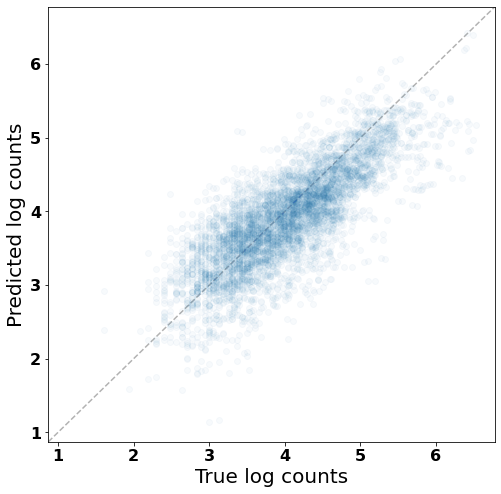

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(np.ravel(true_log_counts), np.ravel(pred_log_counts), alpha=min((1/(len(np.ravel(true_log_counts))))*50000*0.02,0.3))
ax.set_xlabel("True log counts")
ax.set_ylabel("Predicted log counts")
(min_x, max_x), (min_y, max_y) = ax.get_xlim(), ax.get_ylim()
min_both, max_both = min(min_x, min_y), max(max_x, max_y)
ax.set_xlim(min_both, max_both)
ax.set_ylim(min_both, max_both)
ax.plot(
    [min_both, max_both], [min_both, max_both],
    color="black", linestyle="--", alpha=0.3, zorder=0
)
plt.show()

In [25]:
def get_correlations(vec_1, vec_2):
    finite_mask = np.isfinite(vec_1) & np.isfinite(vec_2)
    vec_1 = vec_1[finite_mask]
    vec_2 = vec_2[finite_mask]
    return scipy.stats.pearsonr(vec_1, vec_2)[0], scipy.stats.spearmanr(vec_1, vec_2)[0]

pool_p, pool_s = get_correlations(np.ravel(true_log_counts), np.ravel(pred_log_counts))
pos_p, pos_s = get_correlations(true_log_counts[:, 0], pred_log_counts[:, 0])
neg_p, neg_s = get_correlations(true_log_counts[:, 1], pred_log_counts[:, 1])
avg_p, avg_s = np.mean([pos_p, neg_p]), np.mean([pos_s, neg_s])

header = vdomh.thead(
    vdomh.tr(
        vdomh.th(),
        vdomh.th("Pearson correlation", style={"text-align": "center"}),
        vdomh.th("Spearman correlation", style={"text-align": "center"})
    )
)
body = vdomh.tbody(
    vdomh.tr(
        vdomh.td("Strands pooled"), vdomh.td(str(pool_p)), vdomh.td(str(pool_s))
    ),
    vdomh.tr(
        vdomh.td("Positive strand"), vdomh.td(str(pos_p)), vdomh.td(str(pos_s))
    ),
    vdomh.tr(
        vdomh.td("Negative strand"), vdomh.td(str(neg_p)), vdomh.td(str(neg_s))
    ),
    vdomh.tr(
        vdomh.td("Strands averaged"), vdomh.td(str(avg_p)), vdomh.td(str(avg_s))
    )
)
vdomh.table(header, body)

,Pearson correlation,Spearman correlation
Strands pooled,0.7862634093597289,0.785832965095593
Positive strand,0.7861925285430786,0.7838996521336845
Negative strand,0.7864017871631694,0.7877330858781845
Strands averaged,0.786297157853124,0.7858163690059345
